# Modelo Spark Apache

### Importe o FindSpark

In [1]:
# Import findspark
# Importar o módúlo findspark de modo à utilizar o  
# método .init, responsável por inicializar o spark.
import findspark
findspark.init()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Importe SparkSession

In [3]:
# Import SparkSession
# Após o spark ter sido encontrado no sistema, é necessário criar 
# a Sessão Spark, onde é possível configurar os nós do cluster, 
# bem como a memória alocada para cada um deles.
from pyspark.sql import SparkSession

In [4]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import RandomForestRegressor

In [6]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local[*]") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "6gb") \
   .config('spark.sql.debug.maxToStringFields', 2000) \
   .config('spark.debug.maxToStringFields', 2000) \
   .getOrCreate()
   
sc = spark.sparkContext

### Iniciando o Desenvolvimento com Spark

In [7]:
# Load in the data
rdd = sc.textFile('../datasets/cal_housing.data')

# Load in the header
header = sc.textFile('../datasets/cal_housing.domain')

In [15]:
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [9]:
rdd.take(5)

['-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000',
 '-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000',
 '-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000',
 '-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000',
 '-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000']

In [16]:
def clean_lines(my_rdd): 
    '''loads in a line of RDD and splits by comma'''
    return my_rdd.map(lambda line: line.split(","))
rdd = clean_lines(rdd)

In [17]:
rdd.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

Since RDDs are unweildy, we convert them to dataframes

In [18]:
# First get all the column names out as a list. Once you get a df, you can use df.columns; just wanted to experiment with 
# RDD manipulation
new_header = header.map(lambda line: line.split(':')).map(lambda x: x[0])
COLUMNS = new_header.collect()

In [19]:
from pyspark.sql import Row
df = rdd.map(lambda line: Row(longitude= line[0],
                             latitude = line[1],
                             housingMedianAge = line[2],
                             totalRooms = line[3],
                             totalBedRooms =line[4],
                             population = line[5],
                             households = line[6],
                             medianIncome = line[7],
                             medianHouseValue = line[8])).toDF()

In [20]:
df.show()

+-----------+---------+----------------+-----------+-------------+-----------+-----------+------------+----------------+
|  longitude| latitude|housingMedianAge| totalRooms|totalBedRooms| population| households|medianIncome|medianHouseValue|
+-----------+---------+----------------+-----------+-------------+-----------+-----------+------------+----------------+
|-122.230000|37.880000|       41.000000| 880.000000|   129.000000| 322.000000| 126.000000|    8.325200|   452600.000000|
|-122.220000|37.860000|       21.000000|7099.000000|  1106.000000|2401.000000|1138.000000|    8.301400|   358500.000000|
|-122.240000|37.850000|       52.000000|1467.000000|   190.000000| 496.000000| 177.000000|    7.257400|   352100.000000|
|-122.250000|37.850000|       52.000000|1274.000000|   235.000000| 558.000000| 219.000000|    5.643100|   341300.000000|
|-122.250000|37.850000|       52.000000|1627.000000|   280.000000| 565.000000| 259.000000|    3.846200|   342200.000000|
|-122.250000|37.850000|       52

In [21]:
df.printSchema()
# need to cast string types into float32 or int as needed

root
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- totalRooms: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- population: string (nullable = true)
 |-- households: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)



In [22]:
def cast_columns(df, names, newType):
    ''' cast the columns into type newType'''
    for name in names:
        df = df.withColumn(name, df[name].cast(newType))
    return df

In [23]:
df = cast_columns(df, COLUMNS, FloatType())

In [24]:
# Get some summary statistics
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|          longitude|          latitude|  housingMedianAge|        totalRooms|    totalBedrooms|        population|        households|      medianIncome|  medianHouseValue|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|              20640|             20640|             20640|             20640|            20640|             20640|             20640|             20640|             20640|
|   mean|-119.56970444871473| 35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465| 499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev| 2.0035317429328914|2.1359523806029554|12.585557612111613|2181.6152515827994|421.24790

Data Exploration

It is obvious that certain variables are going to be correlated. For example look at the households and population columns

In [25]:
df.select('population', 'households').sort("population", ascending = False).show(10)

+----------+----------+
|population|households|
+----------+----------+
|   35682.0|    4769.0|
|   28566.0|    6082.0|
|   16305.0|    5358.0|
|   16122.0|    5189.0|
|   15507.0|    5050.0|
|   15037.0|    4072.0|
|   13251.0|    4339.0|
|   12873.0|    3931.0|
|   12427.0|    2826.0|
|   12203.0|    3701.0|
+----------+----------+
only showing top 10 rows



How correlated are the variables?

In [26]:
# convert to vector column first - spark ml requires this before it can output correlations
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


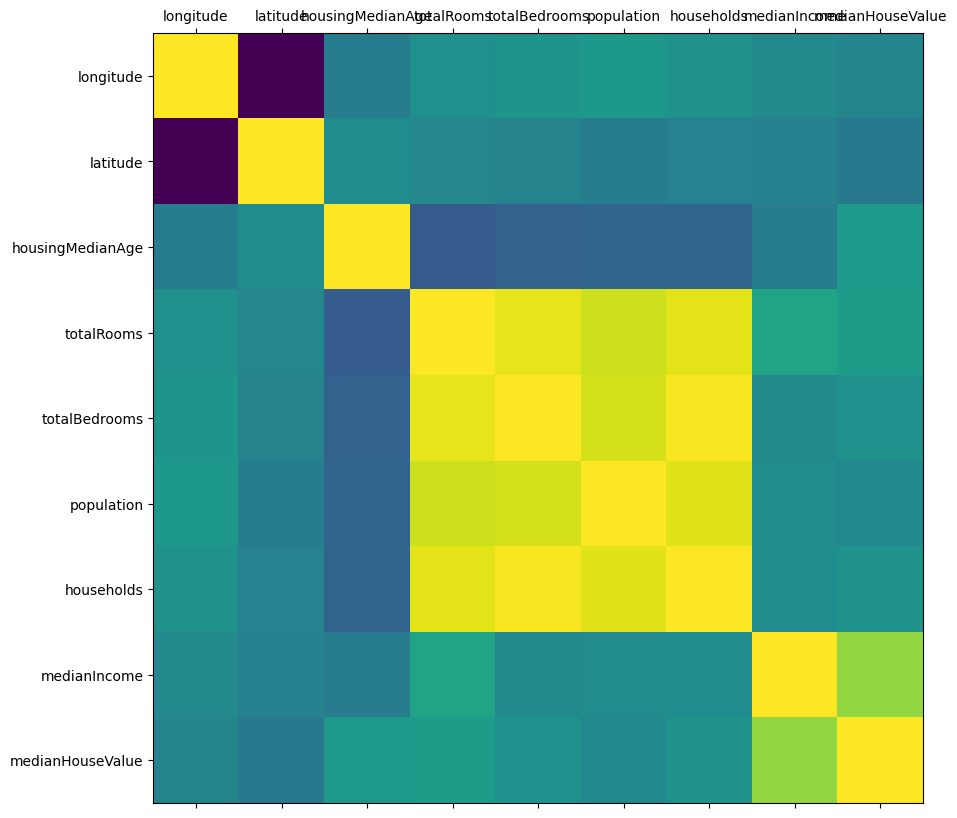

In [27]:
t = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(9, 9)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(t)
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()

Plot histograms and distributions of the data to look for skewness, trends and correlations. This solution is not scalable, but to make plots we have to take subsets of the Spark dataframe and convert to a pandas dataframe. This data is small enough that we can just convert the whole thing.

In [28]:
attributes = ["medianHouseValue", "totalRooms", "households", "housingMedianAge", "medianIncome"]
df_to_pandas = df.toPandas()

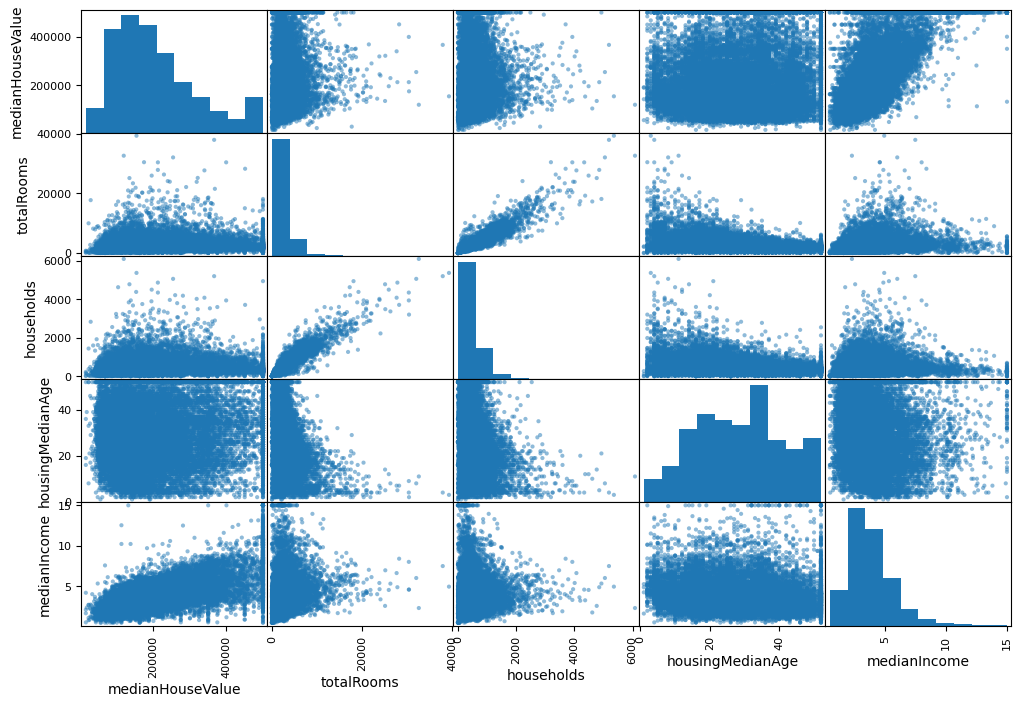

In [29]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_to_pandas[attributes], figsize = (12, 8))
plt.show()

Median income is strongly correlateed with House value. Except that there is a vertical line in the dataset -- very expensive house values around 500K seem to be owned by people of all income groups. It may be worth simply removing that dataset in order to make the model more predictive. Also households and rooms are highly correlated. Median age is also not a normal distribution.

In [30]:
expensive_houses = df.filter(df.medianHouseValue > 500000)

In [31]:
expensive_houses.count()

965